In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner import HyperModel
import visualkeras
from modelling import plot_loss_accuracy_curves, evaluation_metrics

# Load data

In [2]:
data_dir = "..\\..\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images
dest_dir = "..\\..\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories
df = pd.read_csv("..\\..\\DATA\\HAM10000_metadata")  # read metadata
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [3]:
# Load original data
X = []
y = []

for index, row in df.iterrows():
    img_path = os.path.join(data_dir, row["image_id"] + ".jpg")
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img_array)
    y.append(row["diagnosis"])

In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
X.shape

(10015, 128, 128, 3)

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # assign unique int to each class
y = to_categorical(y, num_classes=7)  # convert integers to binary class matrix.

# Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)  # split images into test and train directories

In [8]:
class_counts = np.sum(y_train, axis=0)

In [9]:
class_counts = class_counts.astype(int)

In [10]:
max_images_per_class = 1000

In [11]:
sampling_strategy = {
    i: min(count, max_images_per_class) for i, count in enumerate(class_counts)
}

In [12]:
sampling_strategy

{0: 262, 1: 411, 2: 879, 3: 92, 4: 890, 5: 1000, 6: 114}

In [13]:
rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy, random_state=42
)  # choose random 1000 images for 'nv' class

In [14]:
X_train_over_sampled, y_train_over_sampled = rus.fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train
)

In [15]:
ros = RandomOverSampler()

In [16]:
X_train_balanced, y_train_balanced = ros.fit_resample(
    X_train_over_sampled, y_train_over_sampled
)  # oversample all classes except major one to 1000

In [17]:
X_train_balanced = X_train_balanced.reshape(
    -1, X_train.shape[1], X_train.shape[2], X_train.shape[3]
)

In [18]:
class_names = label_encoder.classes_  # get class names

In [19]:
class_names

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')

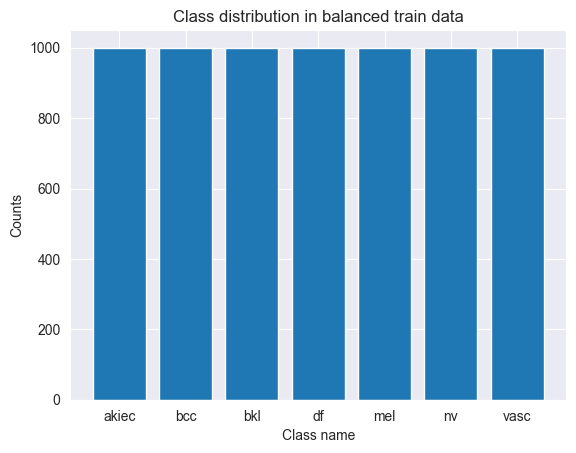

In [20]:
class_counts = np.sum(y_train_balanced, axis=0)
unique = np.unique(class_names)
plt.bar(x=class_names, height=class_counts)
plt.title("Class distribution in balanced train data")
plt.xlabel("Class name")
plt.ylabel("Counts");  # check if train data really is balanced now

# Data augmentation and data flowing

In [21]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    vertical_flip=True,
    fill_mode="reflect",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [22]:
len(X_train_balanced)  # check the size of balanced train data

7000

In [23]:
train_data = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=32)
test_data = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [24]:
tf.random.set_seed(42)  # set tensorflow global random seed

# Define first model 

In [25]:
model_1a = Sequential(
    [
        Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(10, 3, activation="relu"),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [26]:
model_1a.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

In [27]:
history_1a = model_1a.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.2435 - loss: 1.8429 - val_accuracy: 0.4209 - val_loss: 1.3635
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.4318 - loss: 1.4484 - val_accuracy: 0.4933 - val_loss: 1.3397
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 204ms/step - accuracy: 0.4842 - loss: 1.3221 - val_accuracy: 0.4858 - val_loss: 1.2809
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.5115 - loss: 1.2445 - val_accuracy: 0.5017 - val_loss: 1.2636
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.5427 - loss: 1.1626 - val_accuracy: 0.5067 - val_loss: 1.1590


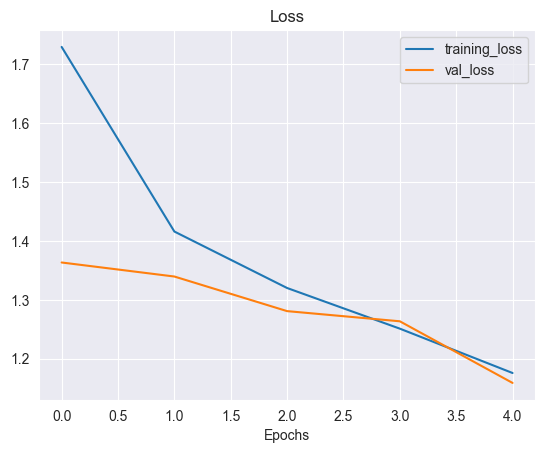

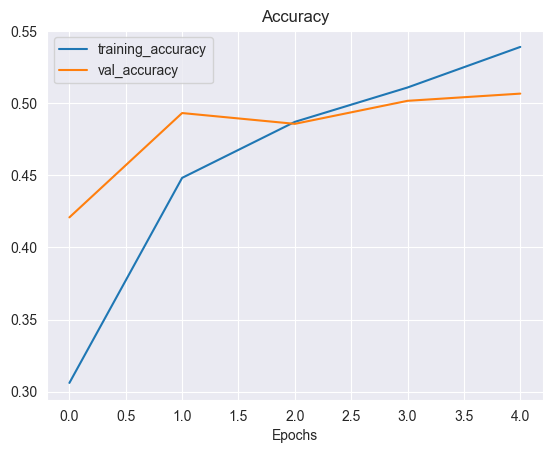

In [28]:
plot_loss_accuracy_curves(history_1a)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


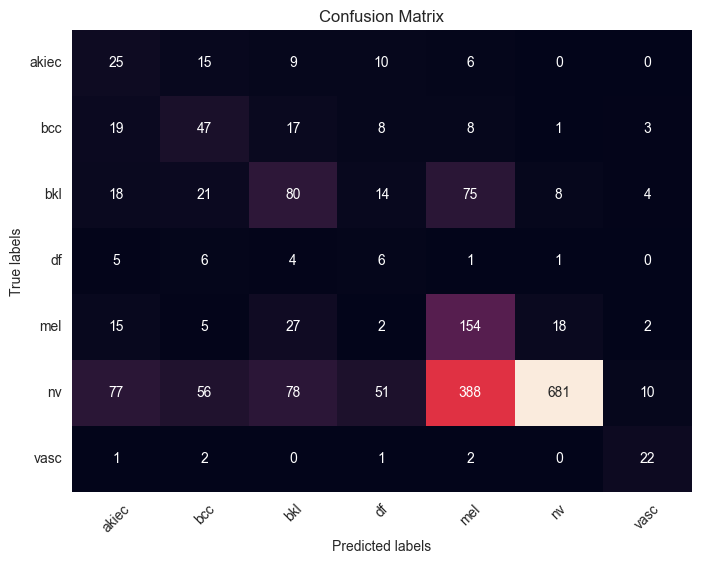

              precision    recall  f1-score   support

       akiec       0.16      0.38      0.22        65
         bcc       0.31      0.46      0.37       103
         bkl       0.37      0.36      0.37       220
          df       0.07      0.26      0.10        23
         mel       0.24      0.69      0.36       223
          nv       0.96      0.51      0.66      1341
        vasc       0.54      0.79      0.64        28

    accuracy                           0.51      2003
   macro avg       0.38      0.49      0.39      2003
weighted avg       0.74      0.51      0.56      2003


In [29]:
evaluation_metrics(model_1a, test_data, y_test, class_names)

Besides the fact that model's accuracy is lower (51%) it performs better (higher recall and F1-score for almost all classes (except 'nv' one), model's predictions are more diverse 

# Trying different CNN architectures

In [30]:
model_2 = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        Conv2D(32, 3, activation="relu"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(64, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        MaxPool2D(2),
        Conv2D(128, 3, activation="relu"),
        Conv2D(128, 3, activation="relu"),
        MaxPool2D(2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)  # more filters (32, 64, 128) and more Conv2D layers

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [31]:
model_2.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
history_2 = model_2.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 199s 887ms/step - accuracy: 0.1748 - loss: 1.9161 - val_accuracy: 0.3270 - val_loss: 1.6487
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 184s 840ms/step - accuracy: 0.2770 - loss: 1.7029 - val_accuracy: 0.3390 - val_loss: 1.4891
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 180s 821ms/step - accuracy: 0.3826 - loss: 1.4864 - val_accuracy: 0.4054 - val_loss: 1.3197
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 182s 817ms/step - accuracy: 0.4115 - loss: 1.4089 - val_accuracy: 0.5087 - val_loss: 1.2048
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 202s 913ms/step - accuracy: 0.4529 - loss: 1.3573 - val_accuracy: 0.5412 - val_loss: 1.1889
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 178s 809ms/step - accuracy: 0.4941 - loss: 1.2788 - val_accuracy: 0.5512 - val_loss: 1.0388
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 191s 871ms/step - accuracy: 0.5120 - loss: 1.2482 - val_accuracy: 0.4164 - val_loss: 1.4199
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 191s 868ms/step - accuracy: 0.5324 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step


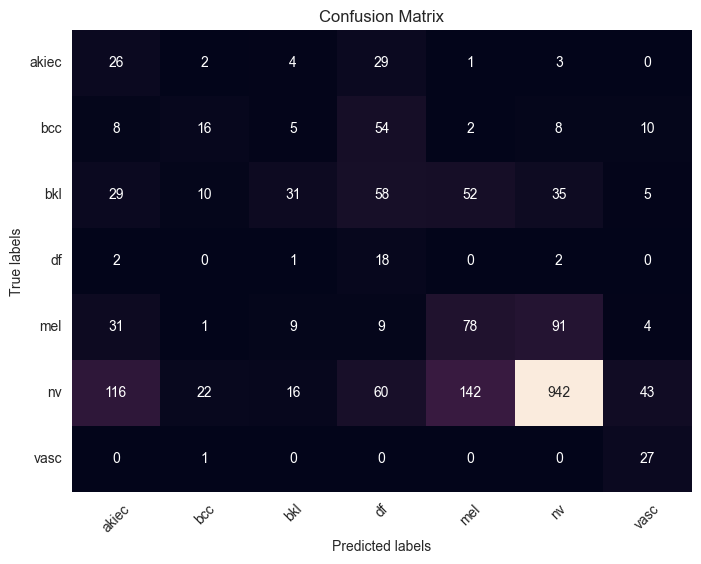

              precision    recall  f1-score   support

       akiec       0.12      0.40      0.19        65
         bcc       0.31      0.16      0.21       103
         bkl       0.47      0.14      0.22       220
          df       0.08      0.78      0.14        23
         mel       0.28      0.35      0.31       223
          nv       0.87      0.70      0.78      1341
        vasc       0.30      0.96      0.46        28

    accuracy                           0.57      2003
   macro avg       0.35      0.50      0.33      2003
weighted avg       0.69      0.57      0.60      2003


In [32]:
evaluation_metrics(model_2, test_data, y_test, class_names)

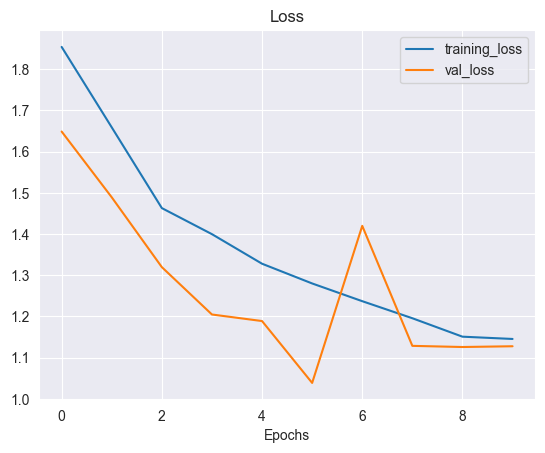

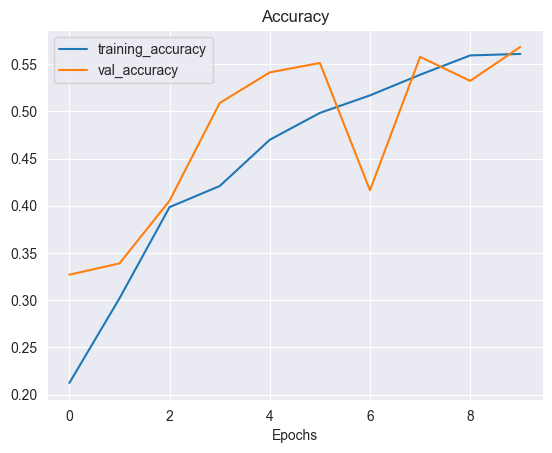

In [33]:
plot_loss_accuracy_curves(history_2)

In [34]:
model_1b = tf.keras.models.clone_model(
    model_1a
)  # clone the architecture of the first model

In [35]:
model_1b.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1b = model_1b.fit(
    train_data, epochs=20, validation_data=test_data
)  # more epochs

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.2315 - loss: 1.8631 - val_accuracy: 0.4613 - val_loss: 1.3504
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.3924 - loss: 1.5403 - val_accuracy: 0.3630 - val_loss: 1.6587
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.4331 - loss: 1.4593 - val_accuracy: 0.5657 - val_loss: 1.2190
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.4677 - loss: 1.3460 - val_accuracy: 0.5112 - val_loss: 1.2742
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.5027 - loss: 1.2671 - val_accuracy: 0.4593 - val_loss: 1.2979
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.5002 - loss: 1.2483 - val_accuracy: 0.4843 - val_loss: 1.3019
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.5193 - loss: 1.2226 - val_accuracy: 0.5662 - val_loss: 1.0446
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.5236 - loss: 1

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


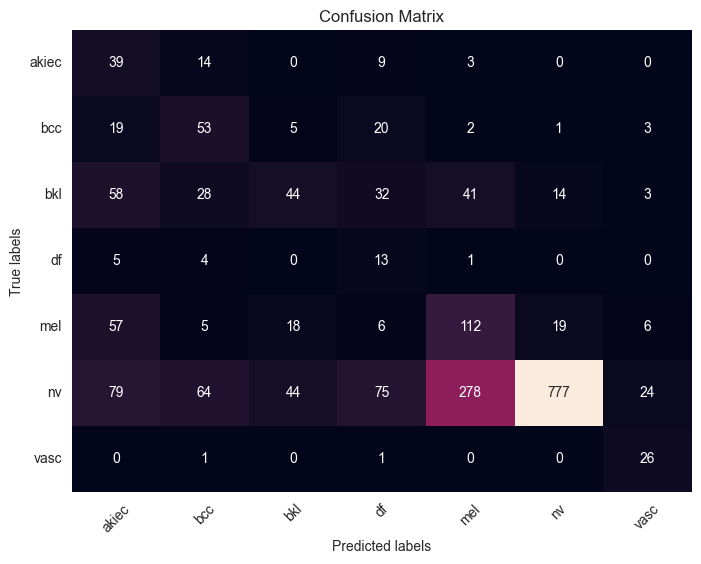

              precision    recall  f1-score   support

       akiec       0.15      0.60      0.24        65
         bcc       0.31      0.51      0.39       103
         bkl       0.40      0.20      0.27       220
          df       0.08      0.57      0.15        23
         mel       0.26      0.50      0.34       223
          nv       0.96      0.58      0.72      1341
        vasc       0.42      0.93      0.58        28

    accuracy                           0.53      2003
   macro avg       0.37      0.56      0.38      2003
weighted avg       0.74      0.53      0.59      2003


In [36]:
evaluation_metrics(model_1b, test_data, y_test, class_names)

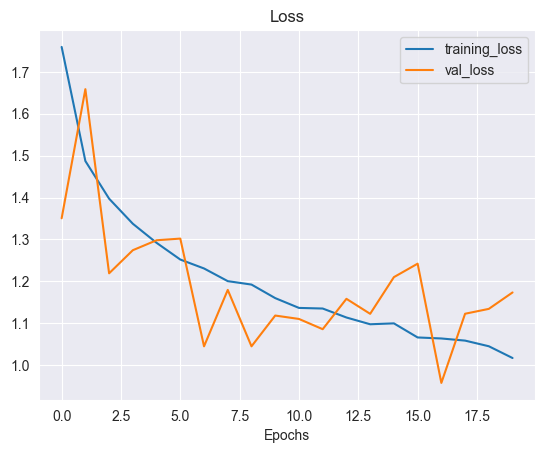

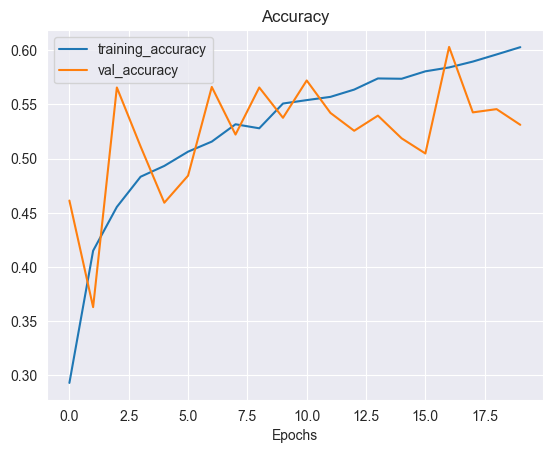

In [37]:
plot_loss_accuracy_curves(history_1b)

In [76]:
model_2b = Sequential(
    [
        BatchNormalization(),
        Conv2D(
            filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3),
            padding="same",
        ),
        Conv2D(32, 3, activation="relu", padding="same"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        Conv2D(128, 3, activation="relu", padding="same"),
        Conv2D(128, 3, activation="relu", padding="same"),
        Conv2D(128, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        Conv2D(256, 3, activation="relu", padding="same"),
        Conv2D(256, 3, activation="relu", padding="same"),
        Conv2D(256, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        BatchNormalization(),
        Conv2D(512, 3, activation="relu", padding="same"),
        Conv2D(512, 3, activation="relu", padding="same"),
        Conv2D(512, 3, activation="relu", padding="same"),
        Flatten(),
        Dropout(0.3),
        Dense(1024, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)  # more Conv2D and Dense layers, extra: one BatchNormalization layer, two Dropout layers

In [77]:
model_2b.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_2b = model_2b.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 646s 3s/step - accuracy: 0.1708 - loss: 2.3469 - val_accuracy: 0.1233 - val_loss: 1.7707
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.2697 - loss: 1.7347 - val_accuracy: 0.6455 - val_loss: 1.1769
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 761s 3s/step - accuracy: 0.2874 - loss: 1.7237 - val_accuracy: 0.2811 - val_loss: 11.5008
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 772s 4s/step - accuracy: 0.2926 - loss: 1.7003 - val_accuracy: 0.5067 - val_loss: 1.3332
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 752s 3s/step - accuracy: 0.2970 - loss: 1.6897 - val_accuracy: 0.5801 - val_loss: 1.2030


In [ ]:
evaluation_metrics(model_2b, train_data, y_test, class_names)

In [ ]:
plot_loss_accuracy_curves(history_2b)

In [114]:
model_1c = Sequential(
    [
        Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(32, 3, activation="relu"),
        Conv2D(32, 3, activation="relu"),
        MaxPool2D(2),
        Conv2D(64, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        MaxPool2D(2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)  # architecture similar to model 1_a, more filters in Conv2D, more Conv2D layers

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [115]:
model_1c.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1c = model_1c.fit(train_data, epochs=20, validation_data=test_data)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 79s 337ms/step - accuracy: 0.1482 - loss: 1.9416 - val_accuracy: 0.5766 - val_loss: 1.5220
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.2619 - loss: 1.7702 - val_accuracy: 0.3470 - val_loss: 1.5801
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.2920 - loss: 1.7027 - val_accuracy: 0.3300 - val_loss: 1.5839
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 316ms/step - accuracy: 0.3270 - loss: 1.6322 - val_accuracy: 0.5642 - val_loss: 1.1350
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 328ms/step - accuracy: 0.4166 - loss: 1.4336 - val_accuracy: 0.5272 - val_loss: 1.2648
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 334ms/step - accuracy: 0.4542 - loss: 1.3352 - val_accuracy: 0.5197 - val_loss: 1.1870
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 372ms/step - accuracy: 0.4935 - loss: 1.2606 - val_accuracy: 0.4898 - val_loss: 1.3099
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 355ms/step - accuracy: 0.4965 - loss: 1

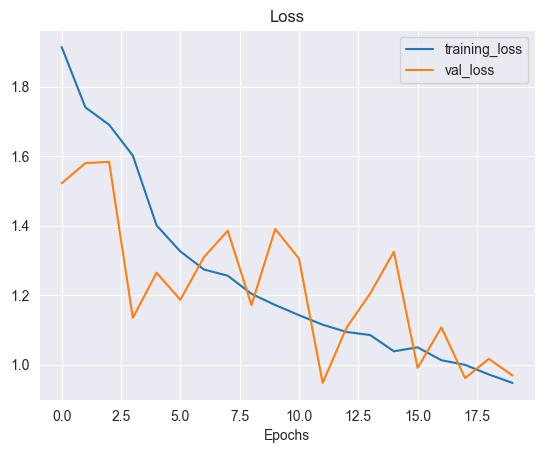

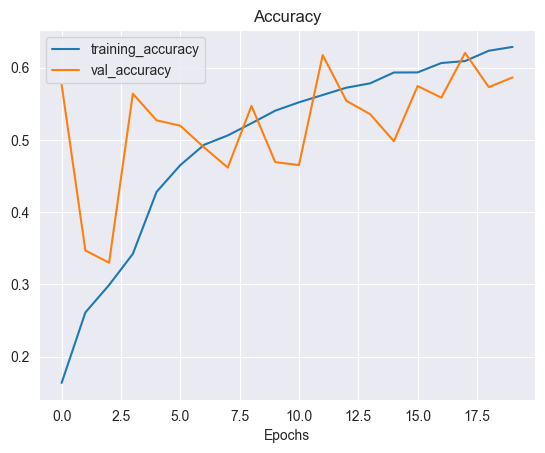

In [116]:
plot_loss_accuracy_curves(history_1c)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step


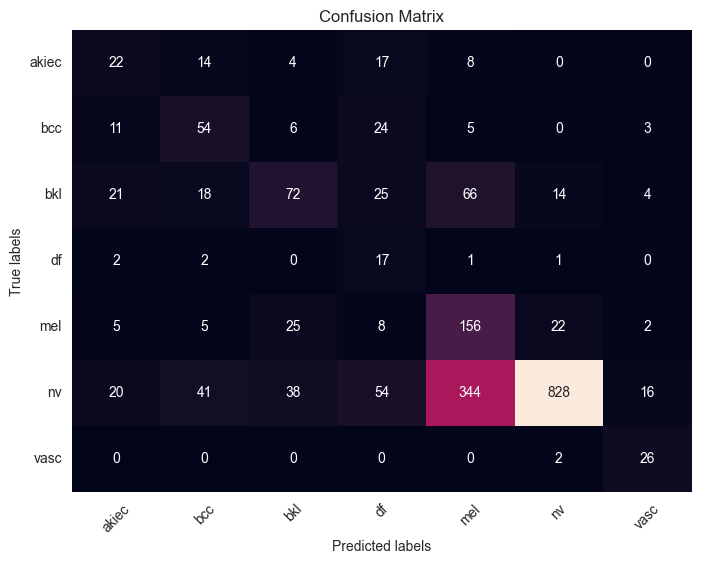

              precision    recall  f1-score   support

       akiec       0.27      0.34      0.30        65
         bcc       0.40      0.52      0.46       103
         bkl       0.50      0.33      0.39       220
          df       0.12      0.74      0.20        23
         mel       0.27      0.70      0.39       223
          nv       0.96      0.62      0.75      1341
        vasc       0.51      0.93      0.66        28

    accuracy                           0.59      2003
   macro avg       0.43      0.60      0.45      2003
weighted avg       0.76      0.59      0.63      2003


In [117]:
evaluation_metrics(model_1c, test_data, y_test, class_names)

In [65]:
model_1f = tf.keras.models.clone_model(model_1a)  # clone architecture of model 1_a

In [66]:
model_1f.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1f = model_1f.fit(
    train_data, epochs=100, validation_data=test_data
)  # change the number of epochs to 100

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.1968 - loss: 1.8837 - val_accuracy: 0.4703 - val_loss: 1.3635
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.3149 - loss: 1.6598 - val_accuracy: 0.4673 - val_loss: 1.2524
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.4222 - loss: 1.3940 - val_accuracy: 0.4314 - val_loss: 1.3298
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.4559 - loss: 1.3180 - val_accuracy: 0.4963 - val_loss: 1.3277
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.4561 - loss: 1.3304 - val_accuracy: 0.5297 - val_loss: 1.1827
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.4991 - loss: 1.2459 - val_accuracy: 0.5147 - val_loss: 1.1642
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.5017 - loss: 1.2049 - val_accuracy: 0.3899 - val_loss: 1.4284
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.4909 -

KeyboardInterrupt: 

KeybordInterrput as accuracy value is not improving since couple of epochs

In [ ]:
model_2c = Sequential(
    [
        BatchNormalization(),
        Conv2D(
            filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3),
            padding="same",
        ),
        Conv2D(32, 3, activation="relu", padding="same"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        Conv2D(128, 3, activation="relu", padding="same"),
        Conv2D(128, 3, activation="relu", padding="same"),
        Conv2D(128, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        Conv2D(256, 3, activation="relu", padding="same"),
        Conv2D(256, 3, activation="relu", padding="same"),
        Conv2D(256, 3, activation="relu", padding="same"),
        MaxPool2D(2),
        BatchNormalization(),
        Conv2D(512, 3, activation="relu", padding="same"),
        Conv2D(512, 3, activation="relu", padding="same"),
        Conv2D(512, 3, activation="relu", padding="same"),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(256, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)  # more complicated architecture, more Conv2D MaxPool2D and Dense layers, more filters, one BatchNormalization layer

In [ ]:
model_2c.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_2c = model_2c.fit(train_data, epochs=5, validation_data=test_data)

In [33]:
model_1g = Sequential(
    [
        Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(32, 3, activation="relu"),
        Conv2D(32, 3, activation="relu"),
        MaxPool2D(2),
        Conv2D(64, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        MaxPool2D(2),
        Conv2D(128, 3, activation="relu"),
        Conv2D(128, 3, activation="relu"),
        Conv2D(128, 3, activation="relu"),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(7, activation="softmax"),
    ]
)  # More Cov2D layers

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [34]:
model_1g.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1g = model_1g.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 382ms/step - accuracy: 0.1399 - loss: 1.9517 - val_accuracy: 0.1098 - val_loss: 1.9443
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 343ms/step - accuracy: 0.1351 - loss: 1.9465 - val_accuracy: 0.0140 - val_loss: 1.9478
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 392ms/step - accuracy: 0.1340 - loss: 1.9461 - val_accuracy: 0.1113 - val_loss: 1.9439
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 106s 472ms/step - accuracy: 0.1326 - loss: 1.9461 - val_accuracy: 0.0140 - val_loss: 1.9466
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 430ms/step - accuracy: 0.1340 - loss: 1.9461 - val_accuracy: 0.0325 - val_loss: 1.9463


Really poor model performance

In [25]:
model_3 = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        BatchNormalization(),
        Conv2D(32, 3, activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(64, 3, activation="relu"),
        BatchNormalization(),
        Conv2D(64, 3, activation="relu"),
        BatchNormalization(),
        MaxPool2D(2),
        Conv2D(128, 3, activation="relu"),
        BatchNormalization(),
        Conv2D(128, 3, activation="relu"),
        BatchNormalization(),
        MaxPool2D(2),
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dense(7, activation="softmax"),
    ]
)  # BatchNormalization layer after each Conv2D layer

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [26]:
model_3.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
history_3 = model_3.fit(train_data, epochs=15, validation_data=test_data)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.3846 - loss: 1.8837 - val_accuracy: 0.0514 - val_loss: 4.9654
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.5237 - loss: 1.2379 - val_accuracy: 0.0944 - val_loss: 5.0934
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.5667 - loss: 1.1431 - val_accuracy: 0.4598 - val_loss: 1.4378
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.6011 - loss: 1.0600 - val_accuracy: 0.5597 - val_loss: 1.3604
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6253 - loss: 0.9961 - val_accuracy: 0.4528 - val_loss: 1.8185
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.6581 - loss: 0.9284 - val_accuracy: 0.4378 - val_loss: 1.5360
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.6828 - loss: 0.8587 - val_accuracy: 0.6026 - val_loss: 1.0674
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.6858 - loss: 0.8337 - val_accu

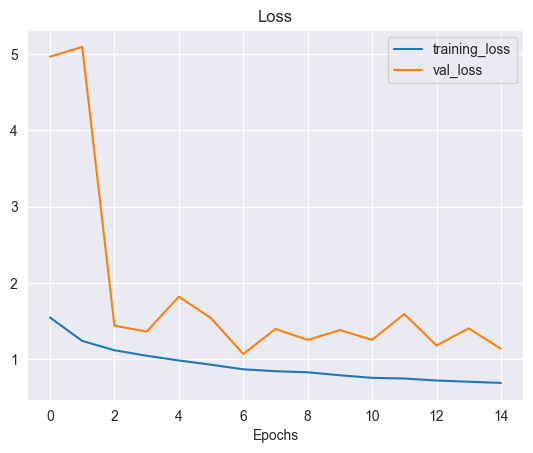

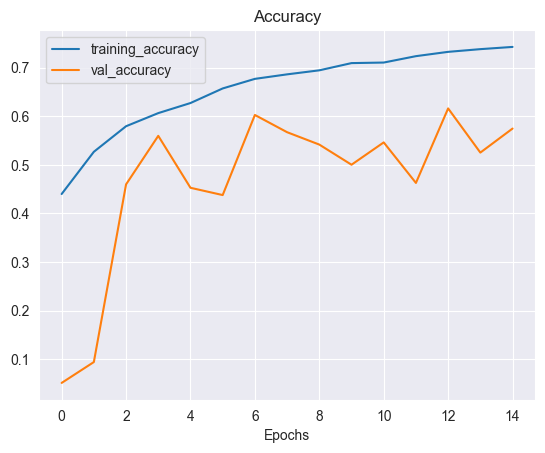

In [32]:
plot_loss_accuracy_curves(history_3)

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step


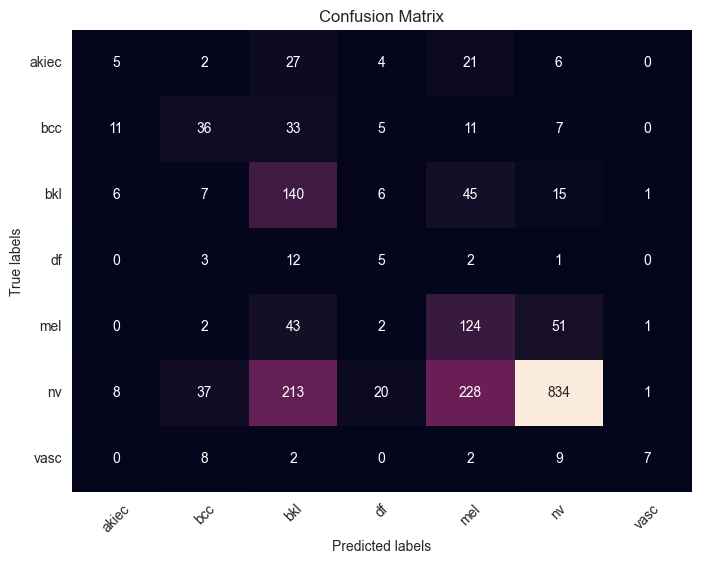

              precision    recall  f1-score   support

       akiec       0.17      0.08      0.11        65
         bcc       0.38      0.35      0.36       103
         bkl       0.30      0.64      0.41       220
          df       0.12      0.22      0.15        23
         mel       0.29      0.56      0.38       223
          nv       0.90      0.62      0.74      1341
        vasc       0.70      0.25      0.37        28

    accuracy                           0.57      2003
   macro avg       0.41      0.39      0.36      2003
weighted avg       0.71      0.57      0.61      2003


In [33]:
evaluation_metrics(model_3, test_data, y_test, class_names)

# Usage of KerasTuner

In [32]:
class CNNHyperModel(HyperModel):
    """
    class used to create a CNN model with various
    hyperparameters for use with Keras Tuner.

    This class inherits from `kerastuner.HyperModel` and is designed to enable
    hyperparameter optimization for different configurations of a CNN. The class
    allows tuning of the number of filters, kernel sizes, number of convolutional
    layers, usage of batch normalization, units in dense layers, dropout usage,
    and learning rate.
    """

    def build(self, hp):
        """
        builds and compiles a CNN model using the hyperparameters provided or
        by randomly choosing hyperparameters during the tuning process.

        :param hp: HyperParameters instance provided by Keras Tuner.
        :return: A compiled Keras Sequential model.
        """
        model = Sequential()

        # First Conv2D Layer
        model.add(
            Conv2D(
                filters=hp.Choice("filters_1", values=[10, 16, 32, 64]),
                kernel_size=hp.Choice("kernel_size_1", values=[3, 5]),
                activation="relu",
                input_shape=(128, 128, 3),
            )
        )
        model.add(MaxPool2D(pool_size=2))

        # Additional Conv2D Layers with fixed kernel_size and batch normalization option
        for i in range(hp.Int("num_conv_layers", 1, 5)):
            model.add(
                Conv2D(
                    filters=hp.Choice(f"filters_{i+2}", values=[32, 64, 128]),
                    kernel_size=3,
                    activation="relu",
                    padding="same",
                )
            )
            model.add(
                Conv2D(
                    filters=hp.Choice(f"filters_{i+2}", values=[32, 64, 128]),
                    kernel_size=3,
                    activation="relu",
                    padding="same",
                )
            )
            if hp.Boolean(f"batch_norm_{i+2}"):
                model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=2))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(
            Dense(units=hp.Choice("dense_units", values=[256, 512]), activation="relu")
        )
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.5))

        # Output layer
        model.add(Dense(7, activation="softmax"))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-3, 1e-4])
            ),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        return model

C:\Users\natal\AppData\Local\Temp\ipykernel_17216\2486705189.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [33]:
hypermodel = CNNHyperModel()  # create an instance of CNNHyperModel class

In [36]:
tuner = kt.RandomSearch(
    hypermodel,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=2,
    project_name="first_tuner",
)  # perform RandomSearch

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
tuner.search(train_data, epochs=10, validation_data=test_data)

Trial 10 Complete [00h 01m 59s]

Best val_loss So Far: 0.8534301221370697
Total elapsed time: 09h 17m 28s


In [38]:
best_model = tuner.get_best_models()[0]  # get the best model

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [46]:
best_model.summary()  # get summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,774,343 (14.40 MB)

 Trainable params: 3,774,087 (14.40 MB)

 Non-trainable params: 256 (1.00 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step


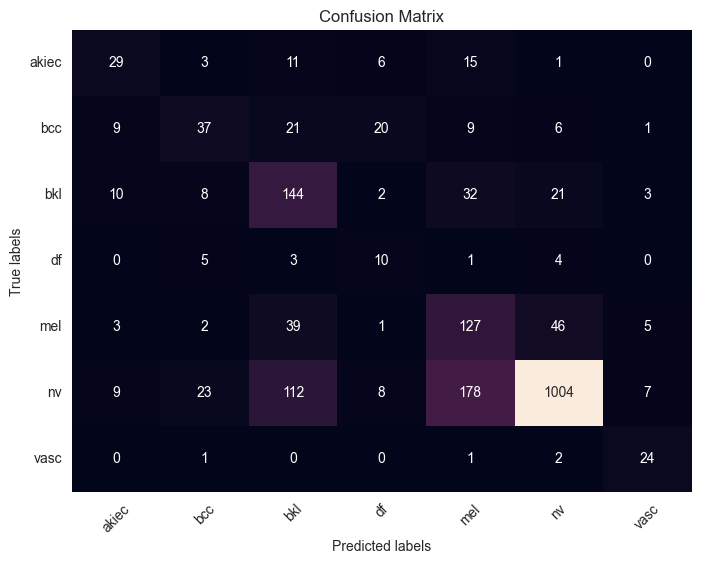

              precision    recall  f1-score   support

       akiec       0.48      0.45      0.46        65
         bcc       0.47      0.36      0.41       103
         bkl       0.44      0.65      0.52       220
          df       0.21      0.43      0.29        23
         mel       0.35      0.57      0.43       223
          nv       0.93      0.75      0.83      1341
        vasc       0.60      0.86      0.71        28

    accuracy                           0.69      2003
   macro avg       0.50      0.58      0.52      2003
weighted avg       0.76      0.69      0.71      2003


In [47]:
evaluation_metrics(best_model, test_data, y_test, class_names)

In [ ]:
best_model.save("CNN_best.keras")  # save the best model in .keras format

# Fitting best model

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True
)  # define early stopping callback that monitors validation data accuracy,
# if validation accuracy is not improving since 8 epochs stops fitting process,
# restores best weights

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.3332 - loss: 1.6726 - val_accuracy: 0.4378 - val_loss: 1.7136
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.5132 - loss: 1.2645 - val_accuracy: 0.3180 - val_loss: 1.5430
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.5594 - loss: 1.1404 - val_accuracy: 0.3575 - val_loss: 1.5011
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.5854 - loss: 1.0606 - val_accuracy: 0.5627 - val_loss: 1.1073
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.6175 - loss: 1.0203 - val_accuracy: 0.6445 - val_loss: 0.9001
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.6187 - loss: 0.9885 - val_accuracy: 0.6465 - val_loss: 0.8793
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6266 - loss: 0.9588 - val_accuracy: 0.6515 - val_loss: 0.9640
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6655 - loss: 0.9051 - val_accuracy

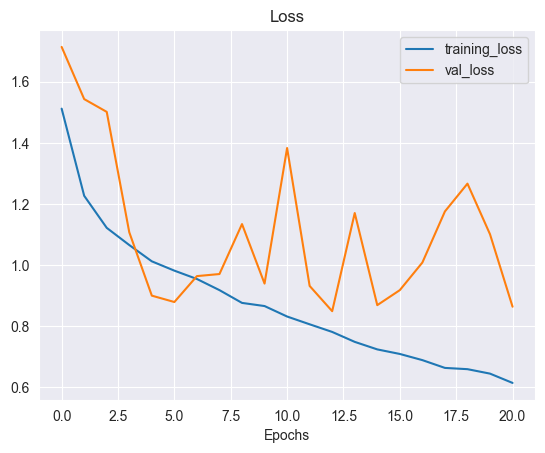

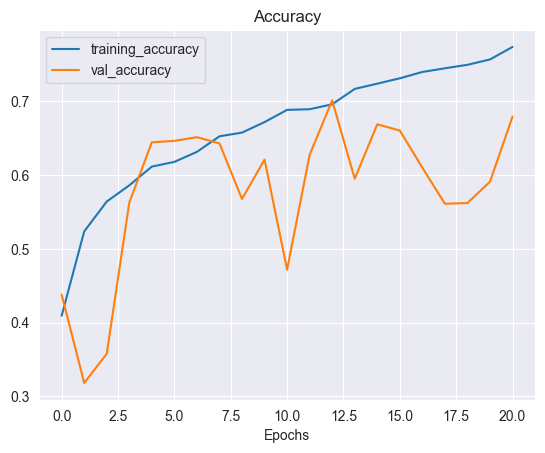

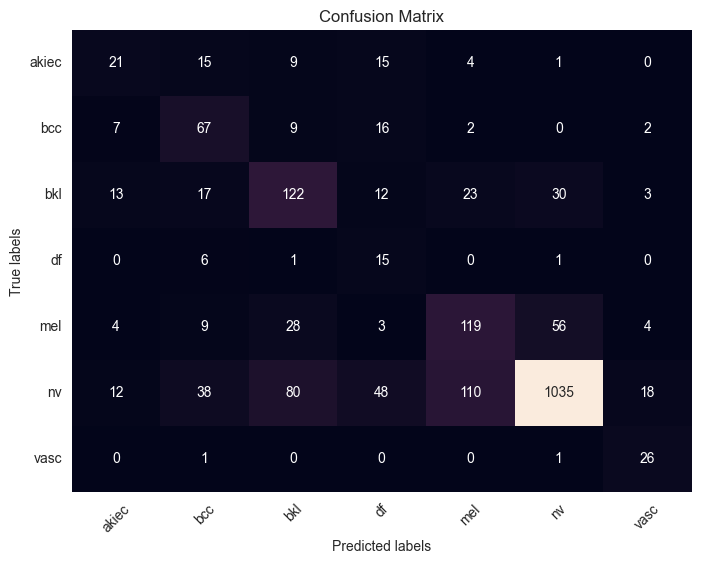

              precision    recall  f1-score   support

       akiec       0.37      0.32      0.34        65
         bcc       0.44      0.65      0.52       103
         bkl       0.49      0.55      0.52       220
          df       0.14      0.65      0.23        23
         mel       0.46      0.53      0.49       223
          nv       0.92      0.77      0.84      1341
        vasc       0.49      0.93      0.64        28

    accuracy                           0.70      2003
   macro avg       0.47      0.63      0.51      2003
weighted avg       0.76      0.70      0.72      2003


In [26]:
best_model_loaded = tf.keras.models.load_model("CNN_best.keras")  # load best model
best_model_cloned_first = tf.keras.models.clone_model(
    best_model_loaded
)  # clone best model
best_model_cloned_first.compile(
    optimizer=Adam(learning_rate=0.0001),  # learning_rate value from saved values
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history_best_model_cloned_first = best_model_cloned_first.fit(
    train_data,
    epochs=100,
    callbacks=[early_stopping_callback],
    validation_data=test_data,
)
plot_loss_accuracy_curves(history_best_model_cloned_first)
evaluation_metrics(best_model_cloned_first, test_data, y_test, class_names)

# Saving best model

In [27]:
best_model_cloned_first.save("CNN_final_model.keras")

In [29]:
best_model_cloned_first.save("CNN_final_model.h5")

In [3]:
CNN_final_model_loaded = tf.keras.models.load_model("CNN_final_model.keras")

In [6]:
visualkeras.layered_view(CNN_final_model_loaded).show() # display using your system viewer

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(CNN_final_model_loaded, to_file='model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
import netron

netron.start('CNN_final_model.keras')


Serving 'CNN_final_model.keras' at http://localhost:8080


('localhost', 8080)